# `MiCRM.jl` 

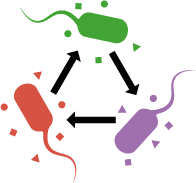

_Simulation of Microbial Consumer Resource (MiCRM) systems in julia._

# Package Aims

* Easy and reproduceable simulations of the MiCRM model
* Modular design to make package easily extendable
* Utilise latest ODE solver tools in `julia` for speed and analysis.  

# The MiCRM Model

\begin{align}
    \frac{dC_i}{dt} &= C_i \left( \sum^{M}_{\alpha} u_{i \alpha} R_{\alpha} (1 - \sum^M_{\beta} l_{\alpha \beta}) - m_i \right) \\
    \frac{dR_{\alpha}}{dt} &= \rho_{\alpha} - 
                              \omega_{\alpha} R_{\alpha} - 
                              \sum^{N}_{i} R_{\alpha} C_i u_{i \alpha} +
                              \sum^{N}_{i} \sum^{M}_{\beta} R_{\beta} C_i u_{i \beta} l_{\beta \alpha}
\end{align}

|          |                        |
|----------|------------------------|
| $u$      | uptake matrix          |
| $m$      | maintenance cost       |
| $\rho$   | resource supply        |
| $\omega$ | resource dilution rate |
| $l$      | leakage                |

# Package Structure

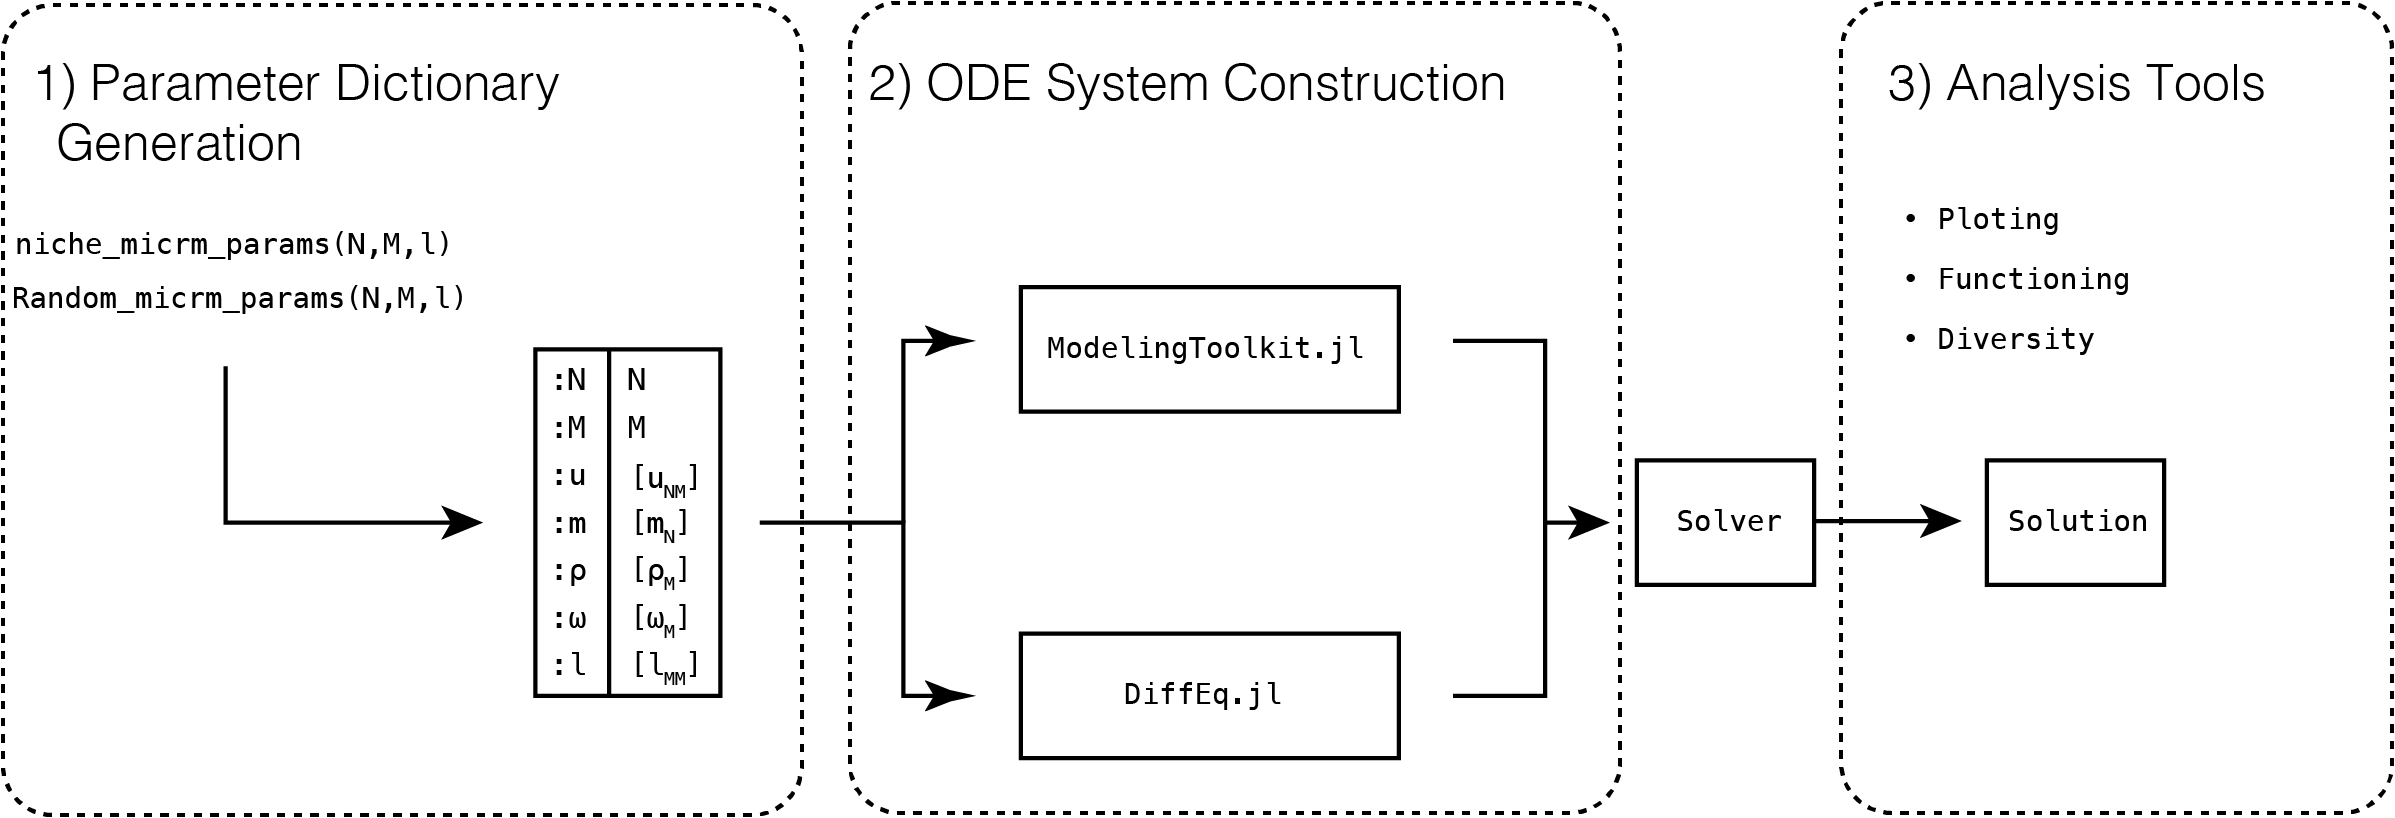

# Parameter Generation

* Functions produce dictionaries of parameters for the MiCRM. 
* Must contain parameters to fully define the model.

## Random model

$u \sim \text{Dir}(\alpha) \ \text{where} \ \alpha = 1.0$ 

$m \sim U(0,1)$

$\rho = 1.0$

$\lambda = 1.0$

$ l \sim \lambda  \text{Dir}(\alpha)$ where $\alpha = 1.0$ and $\lambda$ is the  

In [1012]:
using Pkg, Random

Pkg.activate("..")

using MiCRM, CairoMakie

N = 100
M = 100
l = 0.3

p = MiCRM.random_micrm_params(N,M,l)

  Activating environment at `~/Projects/Working/ErCite/chemicalstressors/Project.toml`


Dict{Symbol, Any} with 7 entries:
  :l => [3.00278e-5 0.0127856 … 0.00168847 0.000190001; 0.00878464 0.00024951 ……
  :m => [0.896016, 0.72513, 0.558972, 0.923483, 0.194064, 0.521673, 0.652066, 0…
  :N => 100
  :M => 100
  :ρ => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.…
  :ω => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.…
  :u => [0.0105545 0.00417383 … 0.00249732 0.00730637; 0.0244532 0.0130161 … 0.…

In [968]:
fig = Figure(resolution = (1000, 400))

hm1 = Axis(fig[1,1], title = "Uptake")
hm2 = Axis(fig[1,2], title = "Respiration", width = 50)
hm3 = Axis(fig[1,3], title = "Inflow", width = 50)
hm4 = Axis(fig[1,4], title = "Outflow", width = 50)
hm5 = Axis(fig[1,5], title = "Leakage")

heatmap!(hm1,p[:u])
heatmap!(hm2,reshape(p[:m],1,N))
heatmap!(hm3,reshape(p[:ρ],1,N))
heatmap!(hm4,reshape(p[:ω],1,N))
heatmap!(hm5,p[:l])

Heatmap{Tuple{Vector{Float32}, Vector{Float32}, Matrix{Float32}}}

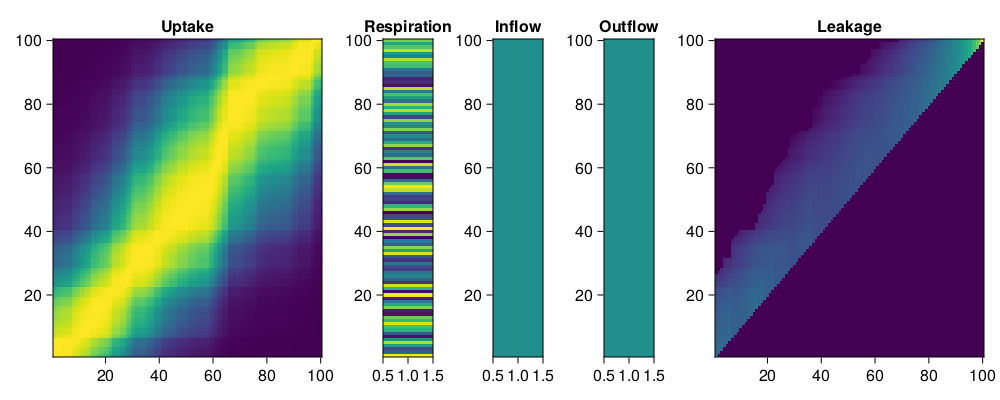

In [1013]:
fig

## Niche model

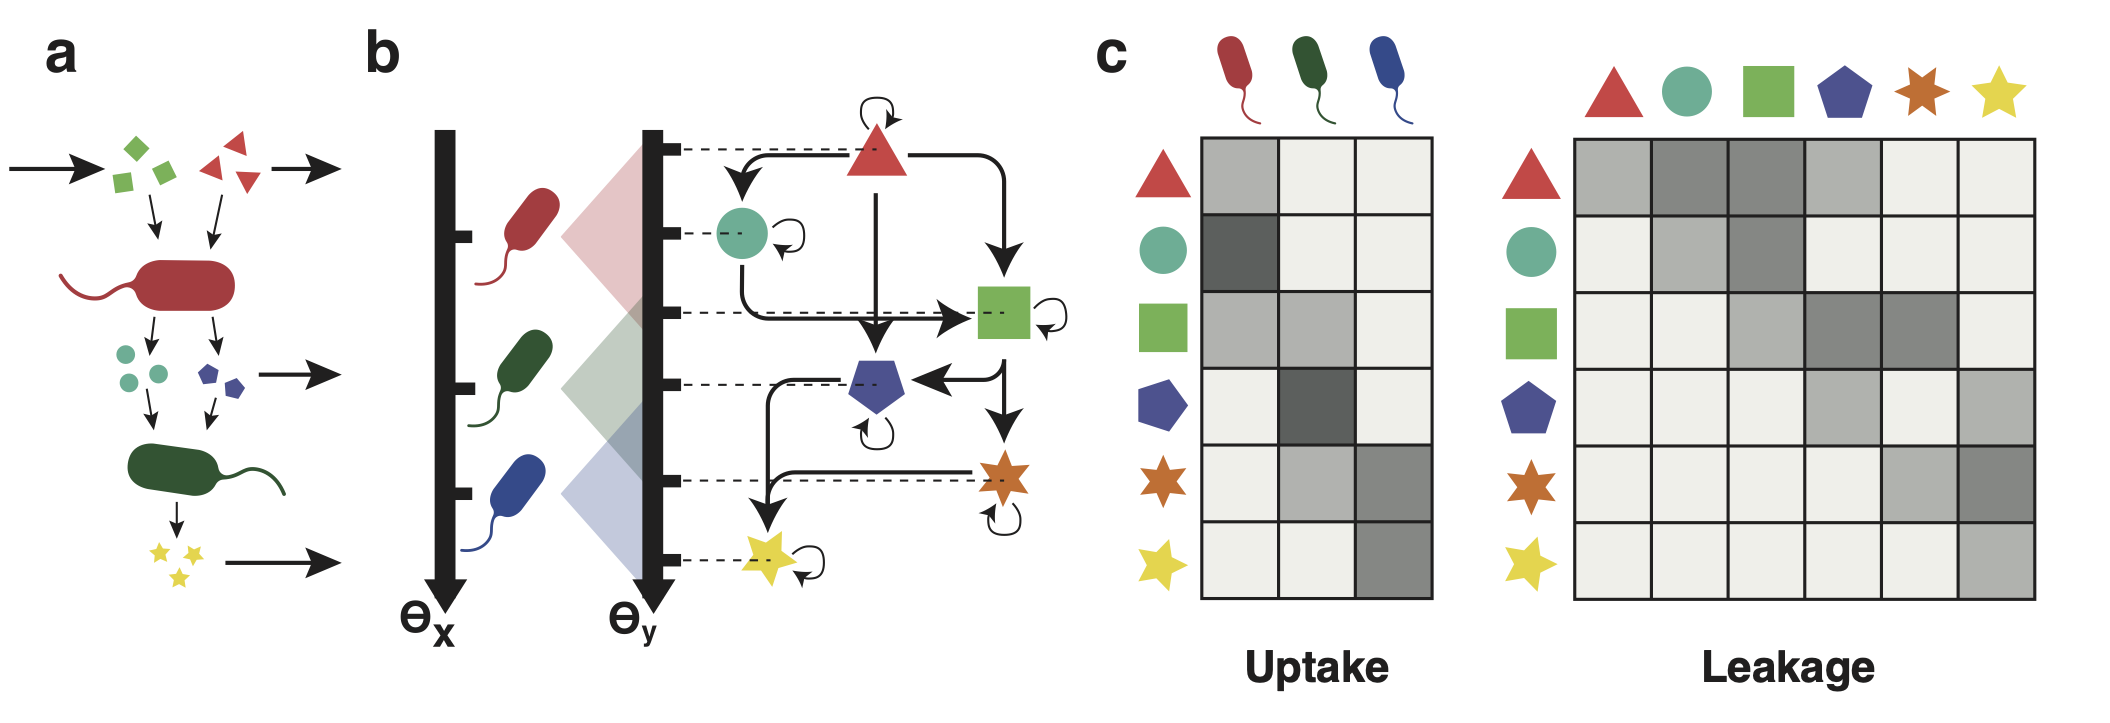

In [971]:
N = M = 100
l = 0.3
p = MiCRM.niche_micrm_params(N,M,l, 1, rand, MiCRM.default_u_func, MiCRM.default_l_func)

fig = Figure(resolution = (1000, 400))

hm1 = Axis(fig[1,1], title = "Uptake")
hm2 = Axis(fig[1,2], title = "Respiration",width = 50)
hm3 = Axis(fig[1,3], title = "Inflow",width = 50)
hm4 = Axis(fig[1,4], title = "Outflow",width = 50)
hm5 = Axis(fig[1,5], title = "Leakage")

heatmap!(hm1,p[:u])
heatmap!(hm2,reshape(p[:m],1,N))
heatmap!(hm3,reshape(p[:ρ],1,N))
heatmap!(hm4,reshape(p[:ω],1,N))
heatmap!(hm5,log.(p[:l]))

Heatmap{Tuple{Vector{Float32}, Vector{Float32}, Matrix{Float32}}}

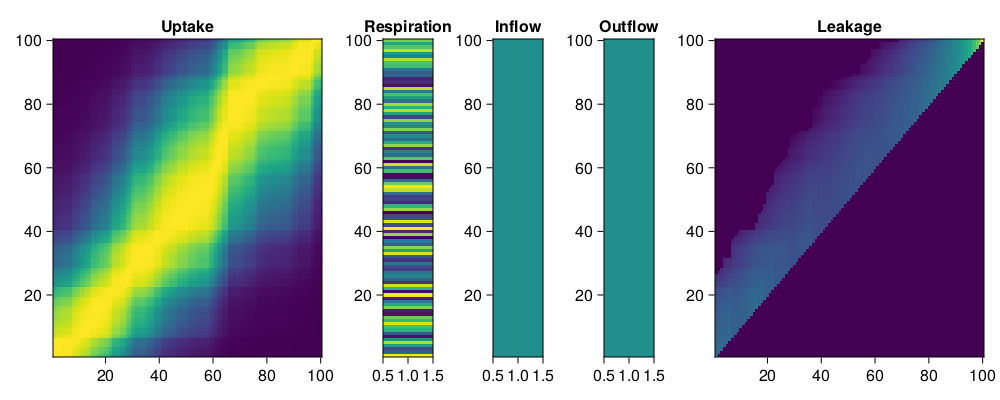

In [972]:
fig

# ODESystem Construction

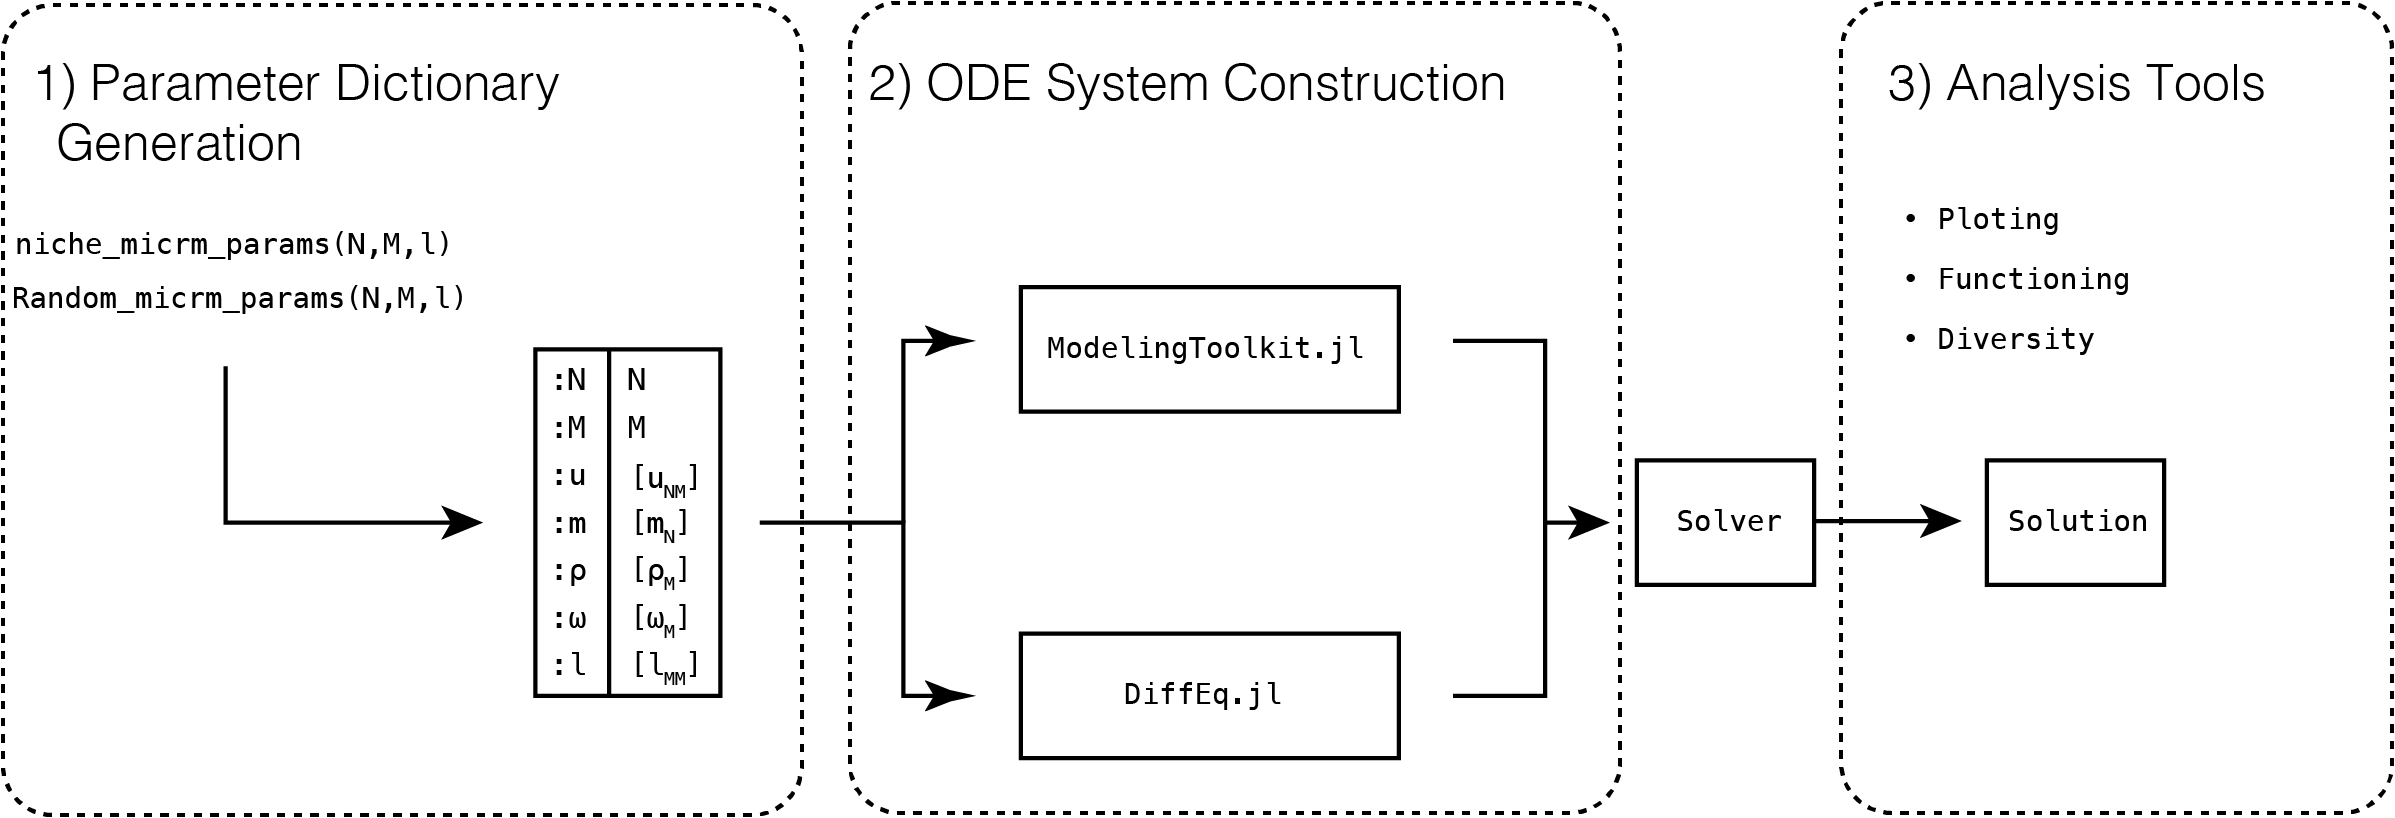

## `ModelingToolkit`

* Symbolic construction of ODE system
* Allows analysis of equations (Jacobians ect.) 
* Long compilation time for larger systems ($N + M > 20$)

In [973]:
Random.seed!(1)
p = MiCRM.random_micrm_params(2,2,0.2)
@named sys = MiCRM.micrm_system(p)

Model sys with 4 equations
States (4):
  C[1](t)
  C[2](t)
  R[1](t)
  R[2](t)
Parameters (14):
  u₁ˏ₁ [defaults to 0.484672]
  l₁ˏ₁ [defaults to 0.104059]
  l₂ˏ₁ [defaults to 0.108561]
  l₂ˏ₂ [defaults to 0.0914393]
  u₁ˏ₂ [defaults to 0.515328]
  l₁ˏ₂ [defaults to 0.095941]
⋮

In [73]:
J = MiCRM.calculate_jacobian(sys)

4×4 Matrix{Num}:
 u₁ˏ₁*R[1](t) + u₁ˏ₂*R[2](t) - m₁ - l₁ˏ₁*u₁ˏ₁*R[1](t) - l₁ˏ₂*u₁ˏ₁*R[1](t) - l₂ˏ₁*u₁ˏ₂*R[2](t) - l₂ˏ₂*u₁ˏ₂*R[2](t)  …                      u₁ˏ₂*C[1](t) - l₂ˏ₁*u₁ˏ₂*C[1](t) - l₂ˏ₂*u₁ˏ₂*C[1](t)
                                                                                                                0                         u₂ˏ₂*C[2](t) - l₂ˏ₁*u₂ˏ₂*C[2](t) - l₂ˏ₂*u₂ˏ₂*C[2](t)
                                                             l₁ˏ₁*u₁ˏ₁*R[1](t) + l₂ˏ₁*u₁ˏ₂*R[2](t) - u₁ˏ₁*R[1](t)                                        l₂ˏ₁*u₁ˏ₂*C[1](t) + l₂ˏ₁*u₂ˏ₂*C[2](t)
                                                             l₁ˏ₂*u₁ˏ₁*R[1](t) + l₂ˏ₂*u₁ˏ₂*R[2](t) - u₁ˏ₂*R[2](t)     l₂ˏ₂*u₁ˏ₂*C[1](t) + l₂ˏ₂*u₂ˏ₂*C[2](t) - ω₂ - u₁ˏ₂*C[1](t) - u₂ˏ₂*C[2](t)

In [974]:
#solving
u0 = [s => 0.1 for s = states(sys)]
tspan = (0.0, 1e3) #define tspan

prob = ODEProblem(sys,u0,tspan,[], jac = true)
@time sol = solve(prob);

  0.000325 seconds (913 allocations: 74.719 KiB)


In [980]:
f = Figure( resoultion = (400,400))
ax = Axis(f[1,1])

[Makie.lines!(ax, sol.t, i) for i = eachrow(sol[:,:])]

4-element Vector{Lines{Tuple{Vector{Point{2, Float32}}}}}:
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}

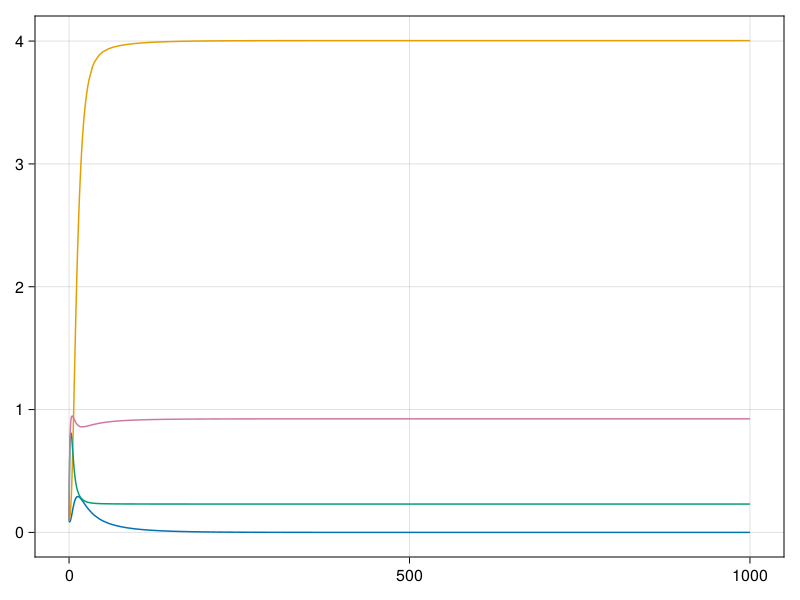

In [981]:
f

In [986]:
#linear stability analysis
#get parameters to subsitute
p_dict = merge(ModelingToolkit.default_p(sys), Dict(s => 0.1 for s = states(sys)))
J_num = Symbolics.substitute.(J, Ref(p_dict))

using LinearAlgebra
eigen([i.val for i = J_num])

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 -1.1220297281811575
 -1.04648494469967
 -0.41352972554023487
 -0.13743514419324707
vectors:
4×4 Matrix{Float64}:
  0.0408873  -0.0713356  -0.996107   -0.0114378
  0.0741074  -0.0141774  -0.0157669   0.996324
 -0.974293    0.120941    0.055127   -0.0847833
  0.208782    0.989992    0.0669543   0.00450412

## `DiffEQ`

* derivative function manualy defined
* allows more complex manipulatuon of solver (callbacks, varying system size)
* (marginaly) slower but no cost of system compilation (better for large numbers of simualtions?)

In [988]:
#converts parameter dictionary to more efficient dedicated parameter type
Random.seed!(2)
p = MiCRM.random_micrm_params(10,10,0.3)
p_diffeq = MiCRM.micrm_params(p) 

u0 = ones(p_diffeq.N + p_diffeq.M)
tspan = (0.0,200.0)
prob = ODEProblem(MiCRM.dx!,u0,tspan,p_diffeq)
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 84-element Vector{Float64}:
   0.0
   0.10255998908785485
   0.2900972782734776
   0.513499017670838
   0.7917394390155221
   1.1153523464017296
   1.4959683811306492
   1.9347355814339804
   2.4433505302220384
   3.028905405485511
   3.6983833175345473
   4.430988135548522
   5.182503423455201
   ⋮
 112.86574067272826
 119.97373322175231
 127.2659826470283
 134.72402769309954
 142.3392323237643
 150.11398506276575
 158.06338103404164
 166.21916212137958
 174.63530180771946
 183.3964843120776
 192.62954870622386
 200.0
u: 84-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.9816410633566591, 1.0657539195197712, 1.0577371314639827, 1.0679905906775924, 0.987375150125686, 1.0179181965185609, 1.0310582229205754, 0.977080679644617, 1.0642793752300237, 1.03527419153298

In [989]:
f = Figure()
ax = Axis(f[1,1])

[CairoMakie.lines!(ax, sol.t, sol[i,:]) for i = 1:(p_diffeq.N + p_diffeq.M)]

20-element Vector{Lines{Tuple{Vector{Point{2, Float32}}}}}:
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}

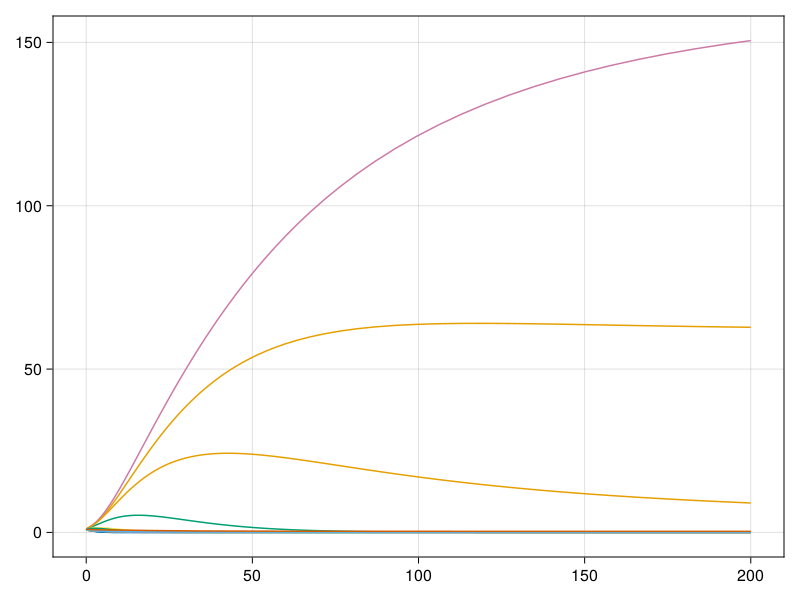

In [990]:
f

# Analysis Tools

* Currently not implemented
* Manipulate the solution objects to get metrics of interest

In [1009]:
#richness
N_final = sum(sol[end][1:p[:N]] .> eps())

#Respiration
R_final = sum(sol[end][1:p[:N]] .* p[:m])

#Relative outflow
ϕ_final = sum((sol[end][p[:N]+1 : end] .* p[:ω])) / sum(p[:ρ])

print("Richness: $N_final \nRespiration: $R_final \nRelative Outflow: $ϕ_final")

Richness: 4 
Respiration: 8.925475703009688 
Relative Outflow: 0.09942590111415481

# Future Steps

## Temperature

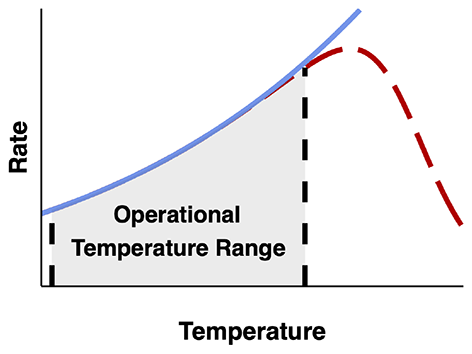

* Add community generators for different temperatures
* Add time varying temperature?

## Marsland et al. Solution 
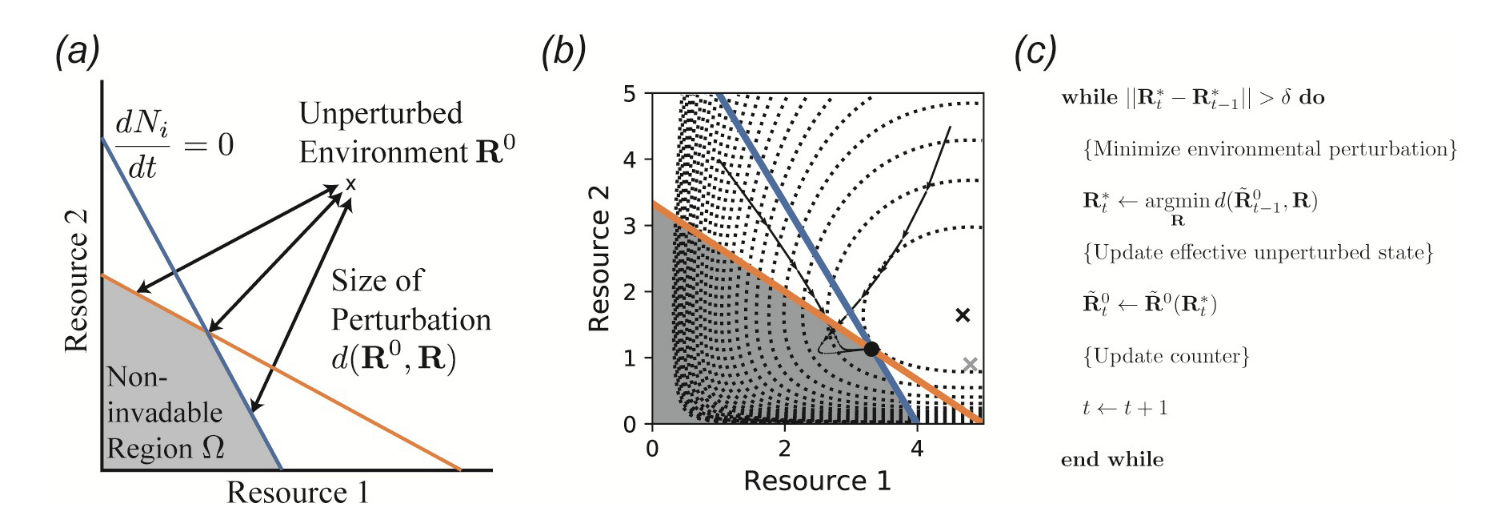

* very efficent at finding solutions (used to solve $N = 1280$ , $M = 1280$ system)

# Examples


## 1) Leakage vs Richness

How does communtiy richness change as leakage increases?

In [631]:
N = 20
M = 20
l = 0.1:0.05:0.9
Nrep = 10

u_func(d) = MiCRM.default_u_func(d, 1000.0)
l_func(d) = MiCRM.default_u_func(d, 1.0)

p = MiCRM.niche_micrm_params(N,M,l[1], 1, rand, u_func, l_func)

#matrix to save results
results = Matrix{Float64}(undef, length(l), Nrep)

#simulation params
#starting mass
u0 = fill(0.1, N+M)
#define tspan
tspan = (0.0, 1e6) 


@time for (i,v) = enumerate(l), r = 1:Nrep
    #create params
    p = MiCRM.niche_micrm_params(N,M,v, 1, rand, u_func , MiCRM.default_l_func)

    #convert to params object
    p = MiCRM.micrm_params(p)
    
    #generate ODEProblem
    prob = MiCRM.ODEProblem(MiCRM.dx!,u0,tspan,p)
    sol = MiCRM.solve(prob, save_everystep = false, AutoTsit5(Rosenbrock23()))
    
    #save richness
    results[i,r]  = sum(sol[end][1:N] .> eps())
end

print("N:$N M:$M", "\ntotal simulations:",length(l) * Nrep)

  5.442698 seconds (292.52 k allocations: 42.940 MiB)
N:20 M:20
total simulations:170

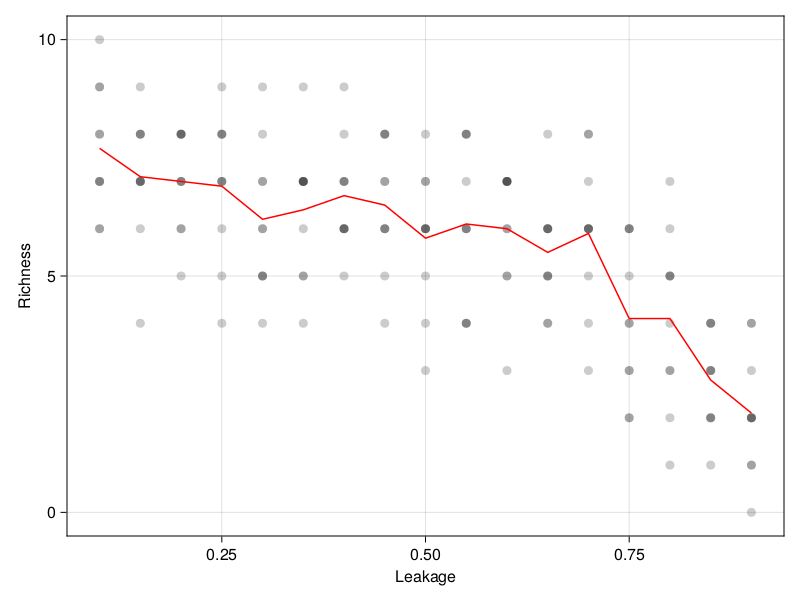

In [632]:
f = Figure()
ax = Axis(f[1,1], xlabel = "Leakage", ylabel = "Richness")

[CairoMakie.scatter!(ax, l, i, color = ("black", 0.2)) for i = eachcol(results)]
CairoMakie.lines!(ax, l, mean(results,dims = 2)[:], color = "red")

f


## 1) Coalescence

What traits explain success when communites coalesce?

In [837]:
#generate 20 random communities
Random.seed!(1)

N_com = 30
N = M = 15

θR = [[i] for i = range(0,1, length = M)]

p = [MiCRM.niche_micrm_params(N,M, 0.1, [rand(1) for i = 1:N] ,  θR, u_func, l_func) for i = 1:N_com]
p = MiCRM.micrm_params.(p)

#starting mass
u0 = fill(0.1, N+M)
#define tspan
tspan = (0.0, 1e6) 
#simulate to get steady states
probs = MiCRM.ODEProblem.(MiCRM.dx!,Ref(u0),Ref(tspan),p)
u_eqs = [solve(p, save_everystep = false, AutoTsit5(Rosenbrock23()))[end][1:N] for p = probs]
#remove ext species
u_eqs = [map(x -> x > eps() ? x : 0.0, u) for u = u_eqs];

In [918]:
#Perform coalescence
A = CartesianIndices(zeros(N_com,N_com))
indxs = [A[i,j] for i = 1:N_com for j = 1:(i-1)]

N_res = length(indxs)
results = zeros(N_res)
@time for i = 1:N_res
    #get communties to coalesce
    i_1,i_2 = Tuple(indxs[i])

    #coalesce parameters
    p_coal = MiCRM.coalesce_communities(p[i_1],p[i_2])

    #get new biomass
    u0 = ones(p_coal.N + p_coal.M)
    u0[1:p_coal.N] .= vcat(u_eqs[i_1][1:N],u_eqs[i_2][1:N])

    prob = MiCRM.ODEProblem(MiCRM.dx!,(u0),(tspan),p_coal)
    sol = solve(prob, save_everystep = false, AutoTsit5(Rosenbrock23()))

    #similarity to previous
        #similarity to previous
    p_c = sol[end][1:p_coal.N] .> 1e-6
    
    p_1 = falses(p_coal.N)
    p_2 = falses(p_coal.N)

    p_1[1:N] .= (u_eqs[i_2][1:N] .> eps())
    p_2[N+1 : end ] .= u_eqs[i_1][1:N] .> eps()

    results[i] = sum(p_c .* ((p_1 / sum(p_1)) .- (p_2 / sum(p_2))))
end

 21.275610 seconds (581.76 k allocations: 90.672 MiB, 0.32% gc time, 0.42% compilation time)


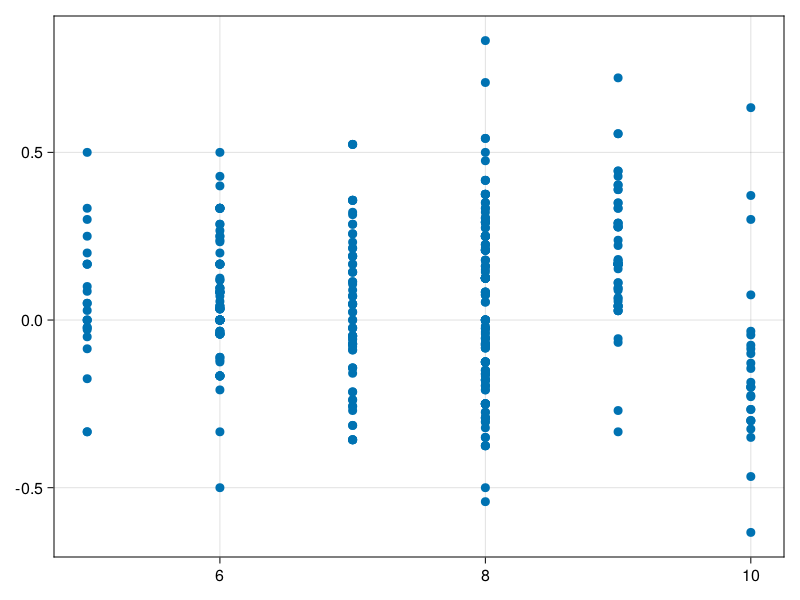

In [939]:
community_N = [sum((u_eqs[i][1:N] .> 0.0)) for i = 1:N_com]

N1 = [community_N[I[1]] for I = indxs]
N2 = [community_N[I[2]] for I = indxs]

N_tot = [results[i] > 0.0 ? N1[i] : N2[i] for i = eachindex(results)]
scatter(N_tot, results)